In [1]:
# Libraries, Variables and Constants

import autogen, os
import json
from dotenv import load_dotenv

load_dotenv("./../credentials_my.env")
cache_seed = 41 # default seed is 41

In [5]:
my_models = [
    {
        'model': os.environ['GPT4-0125PREVIEW-128k'],
        'api_key': os.environ['AZURE_OPENAI_API_KEY_SCUS'],
        "base_url": os.environ['AZURE_OPENAI_ENDPOINT_SCUS'],
        "api_type": os.environ['OPENAI_API_TYPE'],
        "api_version": os.environ['AZURE_OPENAI_API_VERSION']
    },
    {
        'model': os.environ['GPT4-1106-128k'],
        'api_key': os.environ['AZURE_OPENAI_API_KEY'],
        "base_url": os.environ['AZURE_OPENAI_ENDPOINT'],
        "api_type": os.environ['OPENAI_API_TYPE'],
        "api_version": os.environ['AZURE_OPENAI_API_VERSION']
    },
    {
        'model': os.environ['GPT432-0613-32k'],
        'api_key': os.environ['AZURE_OPENAI_API_KEY'],
        "base_url": os.environ['AZURE_OPENAI_ENDPOINT'],
        "api_type": os.environ['OPENAI_API_TYPE'],
        "api_version": os.environ['AZURE_OPENAI_API_VERSION']
    }
]

# need for converting to string
os.environ['models_var'] = json.dumps(my_models)

# Setting configurations for autogen
config_list = autogen.config_list_from_json(
    env_or_file='models_var',
    filter_dict={
        "model": {"gpt4-0125preview-128k", "gpt-4"}
    }
)

config_list

[{'model': 'gpt4-0125preview-128k',
  'api_key': '5948e5b2b4a146cba9940adb3308d731',
  'base_url': 'https://mmopenaiscus.openai.azure.com/',
  'api_type': 'azure',
  'api_version': '2024-02-15-preview'}]

In [6]:
# Setting configurations for autogen
config_list = autogen.config_list_from_json(
    env_or_file='models_list.json',
    filter_dict={ "model": {"gpt4-0125preview-128k", "gpt-4"} }
)

config_list

[{'model': 'gpt4-0125preview-128k',
  'api_key': '5948e5b2b4a146cba9940adb3308d731',
  'base_url': 'https://mmopenaiscus.openai.azure.com/',
  'api_type': 'azure',
  'api_version': '2024-02-15-preview'},
 {'model': 'gpt-4',
  'api_key': 'sk-XoMik5CKuntOhvEJH5QgT3BlbkFjeoQoffxGuvWBf3G3EFKn'}]

In [7]:
llm_config={
        "cache_seed": cache_seed,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    }

llm_config

{'cache_seed': 41,
 'config_list': [{'model': 'gpt4-0125preview-128k',
   'api_key': '5948e5b2b4a146cba9940adb3308d731',
   'base_url': 'https://mmopenaiscus.openai.azure.com/',
   'api_type': 'azure',
   'api_version': '2024-02-15-preview'},
  {'model': 'gpt-4',
   'api_key': 'sk-XoMik5CKuntOhvEJH5QgT3BlbkFjeoQoffxGuvWBf3G3EFKn'}],
 'temperature': 0}

In [8]:
# create a UserProxyAgent instance named "user_proxy"

user_proxy = autogen.UserProxyAgent(
    name                       = "user_proxy",
    human_input_mode           = "NEVER", # NEVER / ALWAYS / TERMINATE
    max_consecutive_auto_reply = 10,

    # if the x["content"] ends by "TERMINATE", is_termination_msg-->True; otherwise, is_termination_msg--> False
    is_termination_msg         = lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    
    code_execution_config = {
        "work_dir": "coding",
        
        # Using docker is safer than running the generated code directly.
        # set use_docker=True if docker is available to run the generated code. 
        "use_docker": False
    },
    
    llm_config=llm_config
)

user_proxy

In [9]:
# create an AssistantAgent named "assistant"

assistant = autogen.AssistantAgent(
    name       = "assistant",
    llm_config = llm_config
)

assistant

In [10]:
%%time
# the assistant receives a message from the user_proxy, which contains the task description in the "message" field

chat_res = user_proxy.initiate_chat(
    assistant,
    message = """What date is today? Compare the year-to-date gain for META and TESLA.""",
    summary_method = "reflection_with_llm",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

First, let's find out today's date using Python. After that, we will proceed to compare the year-to-date (YTD) gain for META (Facebook's parent company, Meta Platforms, Inc.) and TESLA (Tesla, Inc.).

```python
# Step 1: Get today's date
from datetime import datetime

# Print today's date
print(datetime.now().strftime('%Y-%m-%d'))
```

Please run this code to get today's date. After that, we will move on to the next step to compare the YTD gains for META and TESLA.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
2024-04-02


--------------------------------------------------------------------------------
assi

In [11]:
%%time

# followup of the previous question, if needed
user_proxy.send(
    recipient=assistant,
    message="""Please try again and use another way to gather the stock price. For example, use yfinance.""",
)

user_proxy (to assistant):

Please try again and use another way to gather the stock price. For example, use yfinance.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Given the limitations and the request to use `yfinance` for fetching the stock prices, I'll provide a theoretical approach on how you could use `yfinance` to gather the stock prices for META and TESLA to compare their year-to-date (YTD) gains. Since I can't execute or directly fetch the data for you, this explanation will guide you through the process that you can execute in your local Python environment.

### Step-by-Step Guide to Compare YTD Gain for META and TESLA Using `yfinance`:

1. **Install `yfinance`:**
   First, ensure that `yfinance` is installed in your Python environment. You can install it using pip:
   ```sh
   pip install yfinance
   ```

2. **Fetch Stock Data:**
   Use `yfinance` to fetch the historical stock data for META and TESLA from the be

In [ ]:
# autogen.Completion.clear_cache(seed=cache_seed)

In [12]:
i = 1
for cr in chat_res.chat_history:
    print(f'Step {i} --> {cr["content"].rstrip()[-9:]}')
    i=i+1

Step 1 --> nd TESLA.
Step 2 --> nd TESLA.
Step 3 --> 024-04-02
Step 4 --> nd TESLA.
Step 5 --> yfinance'
Step 6 --> ompanies.
Step 7 --> ce-0.2.37
Step 8 --> nd TESLA.
Step 9 --> e to ask!
Step 10 --> TERMINATE
Step 11 --> yfinance.
Step 12 --> e to ask.
Step 13 --> : -29.93%
Step 14 --> TERMINATE


In [13]:
# read the content of the cache

import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect(f'./.cache/{cache_seed}/cache.db')

# Create a cursor object
cur = conn.cursor()

# List all tables in the database
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Tables in this DB: {cur.fetchall()}\n")

# Execute a query
cur.execute("SELECT * FROM Cache")

# Fetch and print the results
for row in cur.fetchall():
    print(row)

# Close the connection
conn.close()

Tables in this DB: [('Settings',), ('Cache',)]

(1, '{"messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"content": "What is autogen?", "role": "user"}], "model": "gpt4-0125preview-128k", "temperature": 0}', 1, 1711981726.0931373, None, 1711981726.0931373, 0, None, 0, 4, None, b'\x80\x05\x95\x9b\n\x00\x00\x00\x00\x00\x00\x8c!openai.types.chat.chat_completion\x94\x8c\x0eChatCompletion\x94\x93\x94)\x81\x94}\x94(\x8c\x08__dict__\x94}\x94(\x8c\x02id\x94\x8c&chatcmpl-99Cw2hENxTeMUhKwU14Ue39RVb7oK\x94\x8c\x07choices\x94]\x94h\x00\x8c\x06Choice\x94\x93\x94)\x81\x94}\x94(h\x05}\x94(\x8c\rfinish_reason\x94\x8c\x04stop\x94\x8c\x05index\x94K\x00\x8c\x08logprobs\x94N\x8c\x07message\x94\x8c)openai.types.chat.chat_completion_message\x94\x8c\x15ChatCompletionMessage\x94\x93\x94)\x81\x94}\x94(h\x05}\x94(\x8c\x07content\x94X\x8a\x06\x00\x00"Autogen" can refer to different things depending on the context in which it\'s used. Here are a few possibilities:\n\n1. **Autogen in Soft

In [14]:
%%time

# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the year-to-date (YTD) stock price changes for META and TESLA, and to save the data to `stock_price_ytd.csv` and the plot to `stock_price_ytd.png`, you can follow the steps outlined in the Python code below. This code uses `yfinance` to fetch the stock data, `pandas` for data manipulation, and `matplotlib` for plotting.

Ensure you have `matplotlib` installed in your environment. If not, you can install it using pip:

```sh
pip install matplotlib
```

Here's the Python code to accomplish the task:

```python
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define the start of the year
start_of_year = datetime.now().year
start_date = f'{start_of_year}-

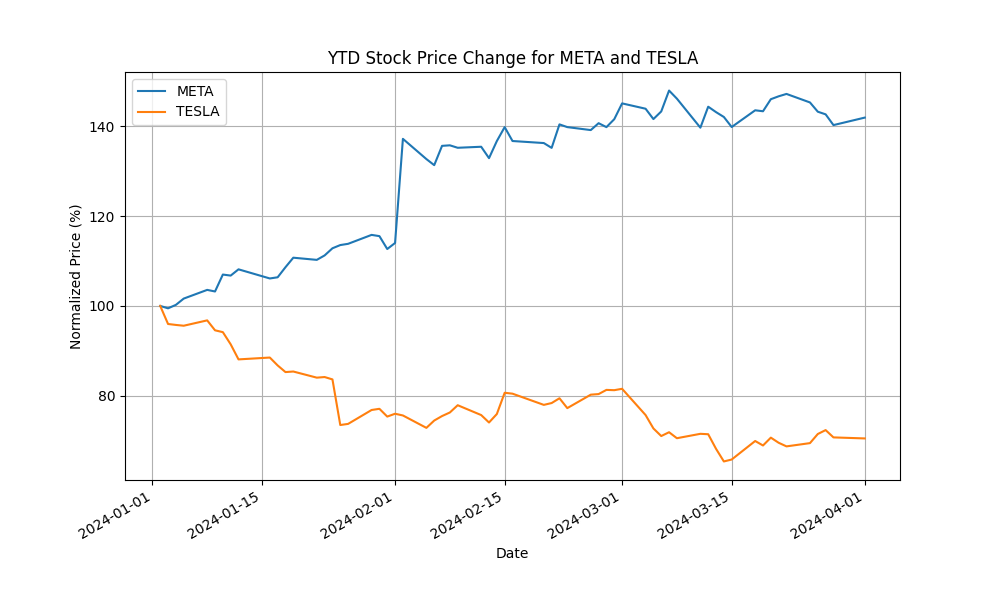

In [15]:
from IPython.display import display, Image

try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")